In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Initial required libraries

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Loading the Dataset
*About the data:* <br>
The data is an twitter comments of various US Airlines having sentiments of the tweet: positive, negative or neutral.

*Columns:* <br>


1.   text: The actual tweet
2.   airline: Name of the airline tweeted about
3. latitude, longitude: Location of the tweet
4. airline_sentiment_confidence : Confidence of the sentiment classification of the tweet
5. airline_sentiment: Sentiment of the tweet


In [3]:
#intializing global variables
data = pd.read_csv('https://raw.githubusercontent.com/anjaliasha123/Data_Visualization_projects/master/Streamlit_python/Tweets.csv')
print(data.text.head(2))
print(data.airline_sentiment.head(2))
data['LABEL'] = 0
data.loc[data.airline_sentiment == 'positive', 'LABEL'] = 0
data.loc[data.airline_sentiment == 'negative', 'LABEL'] = 1
data.loc[data.airline_sentiment == 'neutral', 'LABEL'] = 2
print(data['LABEL'][:10])

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
Name: text, dtype: object
0     neutral
1    positive
Name: airline_sentiment, dtype: object
0    2
1    0
2    2
3    1
4    1
5    1
6    0
7    2
8    0
9    0
Name: LABEL, dtype: int64


In [8]:
dataCopy = data

For the purpose of this project, we are considering only the 'text' column of the Xdata

#MOST COMMON VARIABLES:


*   most_common : for the most common words of the dictionary
*   max_len :
* epochs : Number of times the training of the model must be done. It is a value that determines when a model should stop its training explicitly.
* embed_dim : Dimension of a word vector
* batch_size : size of a batch to train during each itteration of model training


In [7]:
most_common = 20000 #number of vocabs to be considered for the embedding matrix
max_len = 100 
epochs = 10
embed_dim = 100
batch_size = 100

#Data Preprocessing



*   We need to convert y labels into categorical values
*   We need to convert the 



In [4]:
from tensorflow.keras.utils import to_categorical
labels = to_categorical(data['LABEL'], num_classes=3)
print(labels[:10])

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def dataPreprocessing(most_common,X):

  tok = Tokenizer(num_words = most_common,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True)
  tok.fit_on_texts(X.text.values)
  sequences = tok.texts_to_sequences(X.text.values)
  word_index = tok.word_index
  print('Found %s unique tokens.' % len(word_index))
  paddedX = pad_sequences(sequences, maxlen = max_len)
  return paddedX, len(word_index), word_index

pX, size_unique_wordsX, wordIndex = dataPreprocessing(most_common,data)

Found 15768 unique tokens.


#Train-test split
* 80% train data and 20 % test data



In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(pX , labels, test_size=0.2, random_state=42)

In [13]:
print('Training shape X: {} y:{}'.format(X_train.shape, y_train.shape))
print('Testing shape X: {} y:{}'.format(X_test.shape, y_test.shape))

Training shape X: (11712, 100) y:(11712, 3)
Testing shape X: (2928, 100) y:(2928, 3)


#Creating the WordToVector dictionary

In [15]:
def createEmbeddingMatrix(word_index):
  word2vec = {}
  with open(os.path.join('/content/gdrive/My Drive/glove.6B.100d.txt'),encoding='utf8') as f:
      for line in f:
          values = line.rstrip().rsplit(' ')
          word = values[0]
          coefs = np.asarray(values[1:], dtype='float32')
          word2vec[word] = coefs
  num_of_words = min(most_common, len(word_index)+1)
  embedding_matrix = np.zeros((num_of_words,embed_dim))
  for word,i in word_index.items():
      if i < num_of_words:
          embedd_vec = word2vec.get(word)
          if embedd_vec is not None:
              embedding_matrix[i] = embedd_vec
  return embedding_matrix, num_of_words

embedMatrix, num_of_words = createEmbeddingMatrix(wordIndex)

In [17]:
embedMatrix.shape

(15769, 100)

#Creating the Model

In [18]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalMaxPooling1D, Dropout
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Lambda, Dot, Activation, Concatenate
from tensorflow.keras.layers import Conv1D, MaxPooling1D,GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import  Adam

In [21]:
#creating the embedding layer
embedding_layer = Embedding(input_dim=num_of_words,output_dim=max_len,weights=[embedMatrix],input_length=max_len,trainable=False)
#input_layer
input_layer = Input((max_len,),name='InputLayer')
#embedding layer
embedding_layer = embedding_layer(input_layer)
#bi-directional LSTM layer
lstm = Bidirectional(LSTM(50,return_sequences=True))(embedding_layer)
#dropout layer
drop_lstm = Dropout(0.3)(lstm)
#CNN layers
first_conv_layer = Conv1D(128, 3, activation='relu')(lstm)
first_max_pooling_layer = MaxPooling1D(3)(first_conv_layer)
second_conv_layer = Conv1D(128, 4, activation='relu')(first_conv_layer)
second_max_pooling_layer = MaxPooling1D(4)(second_conv_layer)
third_conv_layer = Conv1D(128, 5, activation='relu')(second_max_pooling_layer)
third_max_pooling_layer = MaxPooling1D(5)(third_conv_layer)
merged = Concatenate(axis=1)([first_max_pooling_layer,second_max_pooling_layer,third_max_pooling_layer])
context_vector = GlobalMaxPool1D()(merged)

#attention mechanism
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(100, activation = "relu")
activator = Activation('softmax', name='attention_weights')
dotor = Dot(axes = 1)
hidden_size = int(lstm.shape[2])
h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,), name='last_hidden_state')(lstm)
pre_activation = Concatenate(axis=1)([context_vector, h_t])
e = densor1(pre_activation)
energies = densor2(e)
alphas = activator(energies)
s = dotor([alphas, lstm])
output_layer = Dense(3, use_bias=False, activation='softmax', name='attention_vector')(s)
model = Model(input_layer,output_layer)
model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.01),
        metrics=['accuracy']
             )

In [22]:
from tensorflow.keras.callbacks import Callback
import tensorflow

class MyThresholdCallback(tensorflow.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        acc = logs["accuracy"]
        if acc >= self.threshold:
            self.model.stop_training = True


callback=MyThresholdCallback(threshold=0.95)
r = model.fit(
           X_train, y_train,
            batch_size=50,
            epochs=200,
            validation_split=0.2,
            callbacks=[callback]  
            )

Epoch 1/200
188/188 [==============================] - 47s 224ms/step - loss: 0.6948 - accuracy: 0.7089 - val_loss: 0.6065 - val_accuracy: 0.7593
Epoch 2/200
188/188 [==============================] - 42s 222ms/step - loss: 0.5474 - accuracy: 0.7767 - val_loss: 0.5641 - val_accuracy: 0.7636
Epoch 3/200
188/188 [==============================] - 43s 227ms/step - loss: 0.4744 - accuracy: 0.8068 - val_loss: 0.5467 - val_accuracy: 0.7802
Epoch 4/200
188/188 [==============================] - 43s 229ms/step - loss: 0.4036 - accuracy: 0.8449 - val_loss: 0.5732 - val_accuracy: 0.7734
Epoch 5/200
188/188 [==============================] - 41s 218ms/step - loss: 0.3333 - accuracy: 0.8748 - val_loss: 0.6108 - val_accuracy: 0.7661
Epoch 6/200
188/188 [==============================] - 40s 215ms/step - loss: 0.2624 - accuracy: 0.9019 - val_loss: 0.7381 - val_accuracy: 0.7712
Epoch 7/200
188/188 [==============================] - 40s 213ms/step - loss: 0.1996 - accuracy: 0.9275 - val_loss: 0.8185 -

In [23]:
model.save("bilstmCNNAtt.h5")

<Figure size 432x288 with 0 Axes>

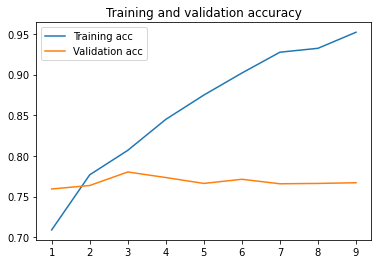

<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt

acc = r.history['accuracy']
val_acc = r.history['val_accuracy']
loss = r.history['loss']
val_loss = r.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

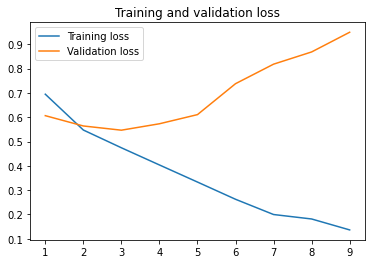

In [25]:
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss,label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [26]:
pred_df = pd.DataFrame()

In [27]:
pred = model.predict(X_test)
pred[0]

array([0.8969502 , 0.03155956, 0.07149021], dtype=float32)

(2928, 100)

In [42]:
pred_df['tweets'] = dataCopy.text.iloc[int(len(dataCopy)*0.8):]
pred_df['actual'] = dataCopy.airline_sentiment.iloc[int(len(dataCopy)*0.8):]
pred_df['predicted'] = None
for i in range(len(X_test)):
  pred_df.predicted.iloc[i] = labels[np.argmax(pred[i])]

In [47]:
pred_df.iloc[1]

tweets       @USAirways Flight Cancelled Flighted because o...
actual                                                negative
predicted                                             negative
Name: 11713, dtype: object

In [48]:
pred_df.to_csv("predictions.csv")

#Model evaluation

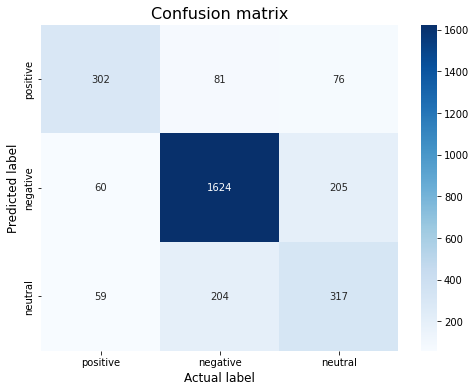

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confusion_matrix(model, X_test, y_test):
    
    sentiment_classes = ['positive', 'negative', 'neutral']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    return cm
    
cm = plot_confusion_matrix(model, X_test, y_test)

In [53]:
cm

array([[ 302,   81,   76],
       [  60, 1624,  205],
       [  59,  204,  317]])

In [56]:
print('Prediction Accuracy: ')
print('Accuracy of Positive class in % : ')
print((cm[0][0]/(cm[0][0]+cm[0][1]+cm[0][2]))*100)
print('Accuracy of Negative class in %: ')
print((cm[1][1]/(cm[1][1]+cm[1][0]+cm[1][2]))*100)
print('Accuracy of Neutral class in %')
print((cm[2][2]/(cm[2][2]+cm[2][0]+cm[2][1]))*100)

Prediction Accuracy: 
Accuracy of Positive class in % : 
65.79520697167756
Accuracy of Negative class in %: 
85.97141344626786
Accuracy of Neutral class in %
54.65517241379311
